# Overlap of global and annual mean temperature trend distributions.

Here we calculate the overlapping between trends distribution for diferent scenarios and plot its evolution acros trend lenght. 

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import random

In [2]:
data = pd.read_csv('../Data/source-data_temperature_trends.csv')
data

,height,Model,Scenarios,Ensemble,Final year,slope,intercept,r_value,p_value,std_err,Time Span
0,TUS,MIROC6,SSP1-1.9,r2i1p1f1,2042,-0.023938,273.026335,-0.718492,0.000359,0.005462,20 years
1,TUS,CanESM5,SSP1-1.9,r14i1p2f1,2037,-0.038328,303.970514,-0.715838,0.002689,0.010369,15 years
2,TUS,CanESM5,SSP1-1.9,r14i1p2f1,2032,-0.086542,401.683109,-0.955419,0.000016,0.009455,10 years
3,TUS,CanESM5,SSP1-1.9,r14i1p2f1,2027,-0.134368,498.526724,-0.965323,0.007711,0.020980,5 years
4,TUS,CanESM5,SSP1-1.9,r14i1p1f1,2042,-0.024521,275.967032,-0.676123,0.001065,0.006298,20 years
...,...,...,...,...,...,...,...,...,...,...,...
7371,GSAT,CanESM5,SSP2-4.5,r9i1p2f1,2037,0.035736,216.354971,0.921948,0.000001,0.004164,15 years
7372,GSAT,CanESM5,SSP2-4.5,r9i1p2f1,2032,0.045755,196.055060,0.917853,0.000180,0.006996,10 years
7373,GSAT,CanESM5,SSP2-4.5,r9i1p2f1,2027,0.004257,280.070193,0.157265,0.800593,0.015435,5 years
7374,GSAT,CanESM5,SSP2-4.5,r9i1p1f1,2037,0.031443,225.231628,0.789917,0.000459,0.006770,15 years


## Percentiles

First we stract the percentile values of each distribution.

In [3]:
quantiles_df = data.groupby(['height', 'Model', 
                             'Scenarios', 'Final year', 
                             'Time Span'])['slope'].quantile([0.10, 0.25,
                                                              0.5, 0.66, 0.75, 0.90]).unstack().reset_index().rename(columns = {  0.10: '10%' ,0.25: 'Q1', 
                                                                                                                         0.5: 'median', 0.75: 'Q3',
                                                                                                                         0.66: '66%',
                                                                                                                       0.90: '90%'})

quantiles_df

,height,Model,Scenarios,Final year,Time Span,10%,Q1,median,66%,Q3,90%
0,GSAT,CanESM5,SSP1-1.9,2027,5 years,-0.033719,0.014449,0.033318,0.047122,0.060328,0.088521
1,GSAT,CanESM5,SSP1-1.9,2032,10 years,0.012857,0.022504,0.032174,0.038266,0.042048,0.054125
2,GSAT,CanESM5,SSP1-1.9,2037,15 years,0.013688,0.020056,0.027732,0.031686,0.032776,0.035208
3,GSAT,CanESM5,SSP1-1.9,2042,20 years,0.017006,0.018401,0.023166,0.025364,0.026174,0.030132
4,GSAT,CanESM5,SSP2-4.5,2027,5 years,-0.023383,0.026251,0.045967,0.061106,0.071408,0.094713
...,...,...,...,...,...,...,...,...,...,...,...
139,TUS,MIROC6,SSP2-4.5,2042,20 years,-0.067798,-0.066910,-0.066381,-0.066170,-0.065930,-0.065314
140,TUS,MIROC6,SSP3-7.0,2027,5 years,-0.159969,-0.154592,-0.147438,-0.140299,-0.135672,-0.131288
141,TUS,MIROC6,SSP3-7.0,2032,10 years,-0.130061,-0.128771,-0.126145,-0.125207,-0.124935,-0.123635
142,TUS,MIROC6,SSP3-7.0,2037,15 years,-0.087947,-0.086309,-0.085405,-0.084699,-0.084129,-0.083231


In [4]:
overleaping = []
cols = ['height', 'Models', 'Scenario ref', 'Scenario comp', 'Time Span', '90_percentil', '10_percentil', 'Final year']
# ssp_ref = 'ssp119'
ssp_test = ['SSP2-4.5', 'SSP3-7.0']

up_limit = '90%'
down_limit = '10%'

for mh in quantiles_df['height'].unique():
    for model in quantiles_df['Model'].unique():
        filter = (quantiles_df['height'] == mh) & (quantiles_df['Model'] == model)
        trends_metric = quantiles_df.loc[filter].reset_index(drop = True)
        for ssp_ref in ['SSP1-1.9', 'SSP2-4.5']:
            filter = (data['height'] == mh) & (data['Model'] == model) & (data['Scenarios'] == ssp_ref)
            ref_data = data.loc[filter].reset_index(drop = True)
            for ssp in ssp_test:
                if ((ssp_ref != ssp)): 
                    for time in trends_metric['Final year'].unique():
                        dt = ref_data.loc[(ref_data['Final year'] == time), 'slope'].values
                        
                        filter = (trends_metric['Scenarios'] == ssp) & (trends_metric['Final year'] == time)
                        x_up = trends_metric.loc[filter, up_limit].values[0]     
                        # print(f'mh {mh}, model {model}, ssp {ssp}, fy {time}\n{x_up}\n')
                        percentile_up = stats.percentileofscore(dt, x_up)

                        x_down = trends_metric.loc[filter, down_limit].values[0]                      
                        percentile_down = stats.percentileofscore(dt, x_down)

                        
                        
                        fy = ref_data.loc[ref_data['Final year'] == time, 'Time Span'].values
                        
                        temp = [mh, model, ssp_ref, ssp, fy[0], percentile_up, percentile_down, time]
                        overleaping.append (dict(zip(cols,temp)))
                
                    


overleaping_df = pd.DataFrame(overleaping)     

overleaping_df

,height,Models,Scenario ref,Scenario comp,Time Span,90_percentil,10_percentil,Final year
0,GSAT,CanESM5,SSP1-1.9,SSP2-4.5,5 years,92.0,14.0,2027
1,GSAT,CanESM5,SSP1-1.9,SSP2-4.5,10 years,88.0,16.0,2032
2,GSAT,CanESM5,SSP1-1.9,SSP2-4.5,15 years,98.0,54.0,2037
3,GSAT,CanESM5,SSP1-1.9,SSP2-4.5,20 years,100.0,94.0,2042
4,GSAT,CanESM5,SSP1-1.9,SSP3-7.0,5 years,90.0,20.0,2027
...,...,...,...,...,...,...,...,...
139,TUS,MIROC6,SSP1-1.9,SSP3-7.0,20 years,0.0,0.0,2042
140,TUS,MIROC6,SSP2-4.5,SSP3-7.0,5 years,60.0,2.0,2027
141,TUS,MIROC6,SSP2-4.5,SSP3-7.0,10 years,0.0,0.0,2032
142,TUS,MIROC6,SSP2-4.5,SSP3-7.0,15 years,0.0,0.0,2037


In [5]:
overleaping_df['Overlapping degree'] = overleaping_df['90_percentil'] - overleaping_df['10_percentil']
overleaping_df['Time'] = overleaping_df['Final year'] - 2022
overleaping_df['Scenarios'] = overleaping_df['Scenario ref'] + ' vs. ' + overleaping_df['Scenario comp']
overleaping_df

,height,Models,Scenario ref,Scenario comp,Time Span,90_percentil,10_percentil,Final year,Overlapping degree,Time,Scenarios
0,GSAT,CanESM5,SSP1-1.9,SSP2-4.5,5 years,92.0,14.0,2027,78.0,5,SSP1-1.9 vs. SSP2-4.5
1,GSAT,CanESM5,SSP1-1.9,SSP2-4.5,10 years,88.0,16.0,2032,72.0,10,SSP1-1.9 vs. SSP2-4.5
2,GSAT,CanESM5,SSP1-1.9,SSP2-4.5,15 years,98.0,54.0,2037,44.0,15,SSP1-1.9 vs. SSP2-4.5
3,GSAT,CanESM5,SSP1-1.9,SSP2-4.5,20 years,100.0,94.0,2042,6.0,20,SSP1-1.9 vs. SSP2-4.5
4,GSAT,CanESM5,SSP1-1.9,SSP3-7.0,5 years,90.0,20.0,2027,70.0,5,SSP1-1.9 vs. SSP3-7.0
...,...,...,...,...,...,...,...,...,...,...,...
139,TUS,MIROC6,SSP1-1.9,SSP3-7.0,20 years,0.0,0.0,2042,0.0,20,SSP1-1.9 vs. SSP3-7.0
140,TUS,MIROC6,SSP2-4.5,SSP3-7.0,5 years,60.0,2.0,2027,58.0,5,SSP2-4.5 vs. SSP3-7.0
141,TUS,MIROC6,SSP2-4.5,SSP3-7.0,10 years,0.0,0.0,2032,0.0,10,SSP2-4.5 vs. SSP3-7.0
142,TUS,MIROC6,SSP2-4.5,SSP3-7.0,15 years,0.0,0.0,2037,0.0,15,SSP2-4.5 vs. SSP3-7.0


## Plot


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.patches import FancyBboxPatch
from matplotlib.lines import Line2D 

sns.set_style("ticks") # { 'ytick.left': "False", 'grid.color': '.95', 'xtick.bottom': "False"}

In [7]:
## here we difine the colour palette
colours = sns.color_palette()

models = overleaping_df['Scenarios'].unique()#The colours will diferenciate the scenarios, so here I extract the scenarios labels

#In this piece of code we create a dictionary that links the colours to the scenarios, this dictionary will be used in the sns.lineplot
index = [1,9, 4]
colors_select = []
for i in index:
    colors_select.append(colours[i])

color_models =(dict(zip(models,colors_select)))

#we also need to create an data frame that will hold the parameters to generate the key for the plots
key_labels = ['Scenarios:',]
for ssp in overleaping_df['Scenarios'].unique():
    key_labels.append(ssp)

key_labels.append('Models:')
for model in overleaping_df['Models'].unique():
    key_labels.append(model) 

key_color = [(1, 1, 1),]
for color in colors_select:
    key_color.append(color)

key_color.append((1, 1, 1))
for i in range(len(overleaping_df['Models'].unique())):
    key_color.append((0, 0, 0))

key_style = ['None','-','-','-','None','-','--', ':']


legend_pars = pd.DataFrame({'label':key_labels, 'color': key_color, 'style': key_style})
legend_pars


,label,color,style
0,Scenarios:,"(1, 1, 1)",None
1,SSP1-1.9 vs. SSP2-4.5,"(1.0, 0.4980392156862745, 0.054901960784313725)",-
2,SSP1-1.9 vs. SSP3-7.0,"(0.09019607843137255, 0.7450980392156863, 0.81...",-
3,SSP2-4.5 vs. SSP3-7.0,"(0.5803921568627451, 0.403921568627451, 0.7411...",-
4,Models:,"(1, 1, 1)",None
5,CanESM5,"(0, 0, 0)",-
6,EC-Earth3,"(0, 0, 0)",--
7,MIROC6,"(0, 0, 0)",:


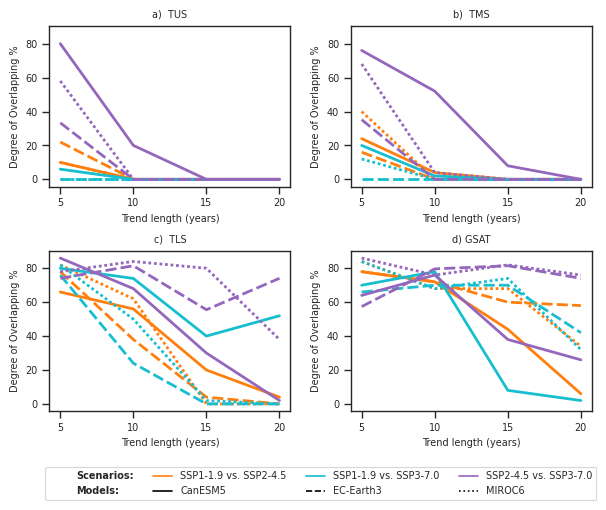

In [8]:
sns.set_context("paper")
fig = plt.figure(figsize=(7.0, 5))
X_var = 'Time'
Y_var = 'Overlapping degree'
hue_var = 'Scenarios'
style_var = 'Models'

xlabel_var = 'Trend length (years)'

x_text = -0.4
y_text = 0.19
text_size = 7

ax0 = plt.subplot(2, 2, 4)
sns.lineplot(data = overleaping_df.loc[(overleaping_df['height'] == 'GSAT') ], 
            x = X_var, y = Y_var, hue = hue_var, style = style_var, 
             style_order = overleaping_df.sort_values(['Models'])['Models'].unique(),
            # hue_order = models,
             lw = 2.0,
           palette = color_models
           )
ax0.set_ylabel('Degree of Overlapping %', fontsize=text_size, fontfamily='sans-serif')
ax0.tick_params(axis='x', labelsize = text_size)  # Remove x-axis tick labels
ax0.tick_params(axis='y', labelsize = text_size)  # Remove x-axis tick labels
ax0.legend([], [], frameon=False) #title = r"$b = D_L\tilde{\sigma}_{atm}$",
ax0.set_title('d) GSAT', fontsize=text_size, fontfamily='sans-serif')
# ax0.set_ylim(-0.26, 0.21)
ax0.set_xlabel(xlabel_var, fontsize=text_size, fontfamily='sans-serif')
ax0.set_xticks([5,10,15,20])

#####################################################################

ax1 = plt.subplot(2, 2, 3, sharey = ax0)
sns.lineplot(data = overleaping_df.loc[(overleaping_df['height'] == 'TLS')], 
            x = X_var, y = Y_var, hue = hue_var, style = style_var, 
             style_order = overleaping_df.sort_values(['Models'])['Models'].unique(),
            # hue_order = models,
             lw = 2.0,
           palette = color_models
           )

ax1.set_ylabel('Degree of Overlapping %', fontsize=text_size, fontfamily='sans-serif')
ax1.tick_params(axis='x', labelsize = text_size)  # Remove x-axis tick labels
ax1.tick_params(axis='y', labelsize = text_size) 
ax1.legend([], [], frameon=False) #title = r"$b = D_L\tilde{\sigma}_{atm}$",
ax1.set_title('c)  TLS', fontsize=text_size, fontfamily='sans-serif') 
ax1.set_xlabel(xlabel_var, fontsize=text_size, fontfamily='sans-serif')
ax1.set_xticks([5,10,15,20])
#####################################################################sort_values
ax2 = plt.subplot(2, 2, 2, sharey = ax1) #sharey = ax1
sns.lineplot(data = overleaping_df.loc[(overleaping_df['height'] == 'TMS')], 
            x = X_var, y = Y_var, hue = hue_var, style = style_var,
             style_order = overleaping_df.sort_values(['Models'])['Models'].unique(),
            # hue_order = models,
             lw = 2.0,
           palette = color_models
           )

ax2.legend([], [], frameon=False) 
ax2.tick_params(axis='x', labelsize = text_size)  # Remove x-axis tick labels
ax2.tick_params(axis='y', labelsize = text_size)   
ax2.set_ylabel('Degree of Overlapping %', fontsize=text_size, fontfamily='sans-serif')
ax2.set_title('b)  TMS', fontsize=text_size, fontfamily='sans-serif') 
ax2.set_xlabel(xlabel_var, fontsize=text_size, fontfamily='sans-serif')
ax2.set_xticks([5,10,15,20])
############################################################################

ax3 = plt.subplot(2, 2, 1, sharey = ax1)
sns.lineplot(data = overleaping_df.loc[(overleaping_df['height'] == 'TUS')], 
            x = X_var, y = Y_var, hue = hue_var, style = style_var,
             style_order = overleaping_df.sort_values(['Models'])['Models'].unique(),
            # hue_order = models,
             lw = 2.0,
           palette = color_models
           )

ax3.tick_params(axis='x', labelsize = text_size)  # Remove x-axis tick labels
ax3.tick_params(axis='y', labelsize = text_size)
ax3.set_ylabel('Degree of Overlapping %', fontsize=text_size, fontfamily='sans-serif')
ax3.set_title('a)  TUS', fontsize=text_size, fontfamily='sans-serif')
ax3.set_xlabel(xlabel_var, fontsize=text_size, fontfamily='sans-serif')
ax3.set_xticks([5,10,15,20])

legend_patches = []
index = [0,4,1,5,2,6,3,7]

for i in index:
    label, color, style  = legend_pars.iloc[i]
    line = Line2D([0], [0], linestyle=style, color=color, label = label)
    legend_patches.append(line)
    
legend =  plt.legend(handles=legend_patches, loc='upper center', 
           # bbox_to_anchor=(0.0, 2.01), 
           
           bbox_to_anchor=(1.125, -1.75), 
           borderaxespad=0, 
           ncol=4, 
           fontsize=text_size,
           
           )
legend.get_texts()[0].set_fontweight('bold')
legend.get_texts()[1].set_fontweight('bold')

plt.subplots_adjust(hspace=0.4, wspace = 0.25) #top = 0.94 wspace = 0.1
plt.savefig(f'../Plots/overlapping_degree{up_limit}-{down_limit}.png', dpi = 500, bbox_inches = 'tight') #facecolor='white'